In [20]:
%matplotlib inline

In [55]:
import pickle as pkl
import seaborn as sb
import matplotlib as mpl
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from graph_tool import load_graph, Graph, GraphView
from graph_tool.topology import kcore_decomposition
from tqdm import tqdm

from graph_helpers import normalize_edges

In [2]:
graph_name = 'grqc'
g = load_graph('data/{}/graph.gt'.format(graph_name))

In [184]:
N = 10
total_B = 1000
B = 1000
methods = ['greedy', 'mf', 'random']

In [185]:
edges_by_method = {}

In [186]:
for m in methods:
    edges_by_method[m] = pkl.load(open('output/{}/{}/B{}-N{}.pkl'.format(graph_name, m, total_B, N), 'rb'))
    assert len(edges_by_method[m]) == total_B
    edges_by_method[m] = edges_by_method[m][:B]

In [187]:
obj_before = sum(kcore_decomposition(g).a)

In [188]:
def get_kcore(g):
    return kcore_decomposition(g).a

In [189]:
def get_kcore_growth(G, edges):
    g = G.copy()
    obj_list = []
    for e in tqdm(edges):
        g.add_edge(*e)
        obj_list.append(sum(get_kcore(g)) - obj_before)
    return obj_list

In [190]:
obj_list_by_method = {}
for m in methods:
    obj_list_by_method[m] = get_kcore_growth(g, edges_by_method[m])

100%|██████████| 1000/1000 [00:06<00:00, 160.48it/s]


In [191]:
plt.style.use('~/.config/matplotlib/stylelib/paper.mplstyle')

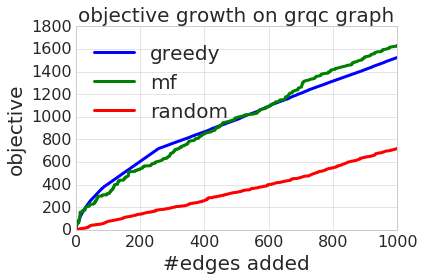

In [192]:
fig = plt.figure()
ax = fig.add_subplot(111)
for m in methods:
    ax.plot(obj_list_by_method[m])
ax.legend(methods, loc='best')
ax.set_xlabel('#edges added')
ax.set_ylabel('objective')
ax.set_title('objective growth on grqc graph')
fig.tight_layout()

fig.savefig('figs/obj_grow/grqc-B{}-N{}.png'.format(B, N))

In [193]:
def get_delta_core_per_node(G, edges):
    g = G.copy()
    kcore_prev = get_kcore(g)
    g.add_edge_list(edges)
    kcore_after = get_kcore(g)
    return kcore_after - kcore_prev

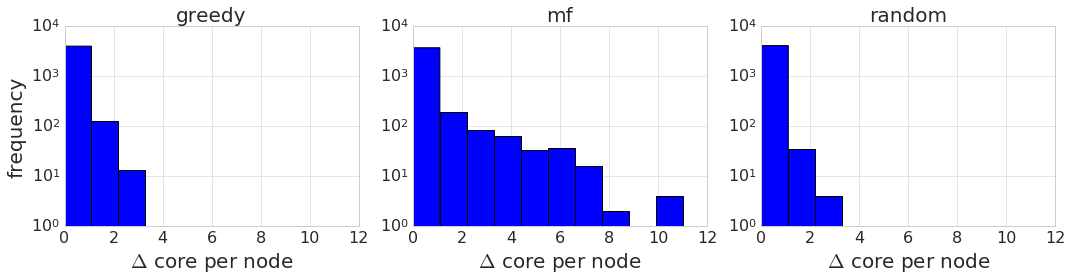

In [194]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
_, bins = np.histogram(get_delta_core_per_node(g, edges_by_method['mf']))

for i, (ax, m) in enumerate(zip(axes, methods)):
    delta = get_delta_core_per_node(g, edges_by_method[m])
    ax.hist(delta, bins=bins, log=True)
    ax.set_xlabel('$\Delta$ core per node')
    if i == 0:    
        ax.set_ylabel('frequency')

    ax.set_title(m)
fig.tight_layout()
    
fig.savefig('figs/delta_core_distribution/grqc-B{}-N{}.png'.format(B, N))    

In [195]:
def kcore_after_adding_edges(G, edges):
    g = G.copy()
    g.add_edge_list(edges)
    kcore_after = get_kcore(g)
    return kcore_after

In [196]:
_, bins = np.histogram(kcore_after_adding_edges(g, edges_by_method['mf']), bins=50)

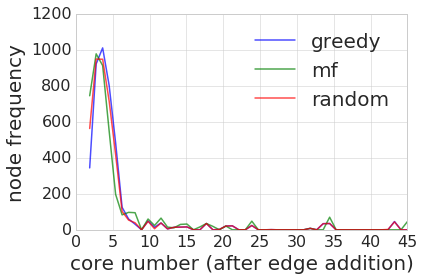

In [197]:
fig = plt.figure()
ax = fig.add_subplot(111)

for m in methods:
    kcore = kcore_after_adding_edges(g, edges_by_method[m])
    # print(m, kcore.max())
    ys, _ = np.histogram(kcore, bins=bins)
    # ys_cum = np.cumsum(ys)
    ax.plot(bins[1:], ys, '-', alpha=0.7, linewidth=1.5)

if False:
    kcore_before = get_kcore(g)
    ys, _ = np.histogram(kcore_before, bins=bins)
    ax.plot(bins[1:], ys, '-', alpha=0.7, linewidth=1.5)
    ax.legend(methods + ['original'], loc='best') 
else:
    ax.legend(methods, loc='best') 

ax.set_xlabel('core number (after edge addition)')
ax.set_ylabel('node frequency')

fig.tight_layout()
fig.savefig('figs/core_distribution/grqc-B{}-N{}.png'.format(B, N))